In [2]:
# ✅ 필요한 라이브러리 불러오기
import os
import time
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio

from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, ReLU
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam

# ✅ Google Drive 마운트 (Colab 사용 시)
from google.colab import drive
drive.mount('/content/drive')

# ✅ 디렉토리 설정
base_dir = "/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10"
generated_samples_dir = f"{base_dir}/generated_samples"
training_checkpoints_dir = f"{base_dir}/training_checkpoints"
training_history_dir = f"{base_dir}/training_history"

os.makedirs(generated_samples_dir, exist_ok=True)
os.makedirs(training_checkpoints_dir, exist_ok=True)
os.makedirs(training_history_dir, exist_ok=True)

print("✅ 폴더 생성 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 폴더 생성 완료!


In [3]:
# ✅ CIFAR-10 데이터셋 로드 및 전처리
(train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_x = (train_x.astype("float32") - 127.5) / 127.5  # [-1, 1]로 정규화
train_x = np.reshape(train_x, (-1, 32, 32, 3))

# ✅ 미니배치 구성
BATCH_SIZE = 256
BUFFER_SIZE = 60000

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

print("✅ 데이터셋 로드 및 전처리 완료!")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ 데이터셋 로드 및 전처리 완료!


In [4]:
# ✅ 생성자(Generator) 모델 구현
def build_generator():
    model = tf.keras.Sequential([
        Dense(8*8*256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        ReLU(),
        Reshape((8, 8, 256)),

        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(3, (5, 5), strides=(1, 1), padding="same", activation="tanh"),
    ])
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,507 (10.43 MB)

 Trainable params: 2,700,355 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [5]:
# ✅ 판별자(Discriminator) 모델 구현
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(32, 32, 3)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dense(1, activation="sigmoid"),
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,034,881 (3.95 MB)

 Trainable params: 1,034,113 (3.94 MB)

 Non-trainable params: 768 (3.00 KB)

In [6]:
# ✅ 손실 함수 및 최적화 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# ✅ 체크포인트 설정
checkpoint_prefix = f"{training_checkpoints_dir}/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
# ✅ 학습 손실 기록을 위한 리스트
gen_losses = []
disc_losses = []

# ✅ 학습 과정
EPOCHS = 200
noise_dim = 100
seed = tf.random.normal([16, noise_dim])  # 16개의 고정된 seed

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_epoch = 0
        disc_loss_epoch = 0
        batch_count = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += gen_loss
            disc_loss_epoch += disc_loss
            batch_count += 1

        gen_losses.append(gen_loss_epoch / batch_count)
        disc_losses.append(disc_loss_epoch / batch_count)

        print(f"Epoch {epoch+1}/{epochs} 완료, 시간: {time.time()-start:.2f}초, "
              f"G_loss: {gen_losses[-1]:.4f}, D_loss: {disc_losses[-1]:.4f}")

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    plot_train_history()

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')

    plt.savefig(f"{generated_samples_dir}/image_at_epoch_{epoch}.png")
    plt.show()

def plot_train_history():
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss History")
    plt.savefig(f"{training_history_dir}/training_loss.png")
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/200 완료, 시간: 12.99초, G_loss: 7.2412, D_loss: 0.1015
Epoch 2/200 완료, 시간: 3.48초, G_loss: 5.9769, D_loss: 0.0422
Epoch 3/200 완료, 시간: 3.47초, G_loss: 5.6326, D_loss: 0.0249
Epoch 4/200 완료, 시간: 3.48초, G_loss: 6.3092, D_loss: 0.0109
Epoch 5/200 완료, 시간: 3.56초, G_loss: 5.9289, D_loss: 0.0143
Epoch 6/200 완료, 시간: 3.48초, G_loss: 5.0511, D_loss: 0.0438
Epoch 7/200 완료, 시간: 3.48초, G_loss: 5.5034, D_loss: 0.0447
Epoch 8/200 완료, 시간: 3.49초, G_loss: 5.1535, D_loss: 0.0411
Epoch 9/200 완료, 시간: 3.49초, G_loss: 5.1440, D_loss: 0.0778
Epoch 10/200 완료, 시간: 3.47초, G_loss: 5.1153, D_loss: 0.1092


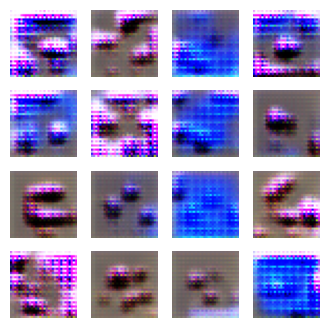

Epoch 11/200 완료, 시간: 3.48초, G_loss: 5.3835, D_loss: 0.0642
Epoch 12/200 완료, 시간: 3.48초, G_loss: 4.8634, D_loss: 0.0880
Epoch 13/200 완료, 시간: 3.47초, G_loss: 4.4757, D_loss: 0.1489
Epoch 14/200 완료, 시간: 3.48초, G_loss: 3.8386, D_loss: 0.1717
Epoch 15/200 완료, 시간: 3.47초, G_loss: 3.6516, D_loss: 0.2130
Epoch 16/200 완료, 시간: 3.47초, G_loss: 3.6420, D_loss: 0.1700
Epoch 17/200 완료, 시간: 3.48초, G_loss: 3.8120, D_loss: 0.1574
Epoch 18/200 완료, 시간: 3.47초, G_loss: 3.5061, D_loss: 0.2225
Epoch 19/200 완료, 시간: 3.48초, G_loss: 3.3505, D_loss: 0.2358
Epoch 20/200 완료, 시간: 3.46초, G_loss: 3.2500, D_loss: 0.2035


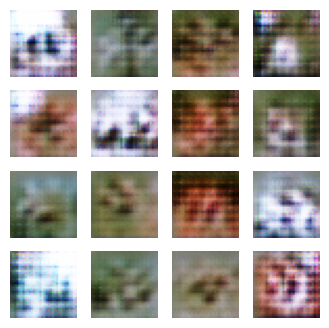

Epoch 21/200 완료, 시간: 3.47초, G_loss: 3.2517, D_loss: 0.2297
Epoch 22/200 완료, 시간: 3.52초, G_loss: 3.4234, D_loss: 0.1907
Epoch 23/200 완료, 시간: 3.47초, G_loss: 3.4373, D_loss: 0.2101
Epoch 24/200 완료, 시간: 3.47초, G_loss: 3.5091, D_loss: 0.2297
Epoch 25/200 완료, 시간: 3.47초, G_loss: 3.2140, D_loss: 0.2813
Epoch 26/200 완료, 시간: 3.48초, G_loss: 3.0120, D_loss: 0.3046
Epoch 27/200 완료, 시간: 3.47초, G_loss: 2.7116, D_loss: 0.3804
Epoch 28/200 완료, 시간: 3.47초, G_loss: 2.8263, D_loss: 0.3468
Epoch 29/200 완료, 시간: 3.47초, G_loss: 2.7953, D_loss: 0.4083
Epoch 30/200 완료, 시간: 3.47초, G_loss: 2.8530, D_loss: 0.3895


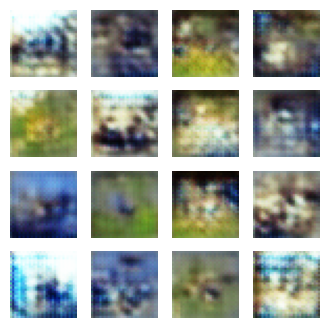

Epoch 31/200 완료, 시간: 3.47초, G_loss: 2.5189, D_loss: 0.4371
Epoch 32/200 완료, 시간: 3.47초, G_loss: 2.6116, D_loss: 0.4036
Epoch 33/200 완료, 시간: 3.48초, G_loss: 2.6678, D_loss: 0.3574
Epoch 34/200 완료, 시간: 3.47초, G_loss: 2.7058, D_loss: 0.4677
Epoch 35/200 완료, 시간: 3.47초, G_loss: 3.1358, D_loss: 0.3223
Epoch 36/200 완료, 시간: 3.47초, G_loss: 2.5585, D_loss: 0.4080
Epoch 37/200 완료, 시간: 3.47초, G_loss: 2.4534, D_loss: 0.4227
Epoch 38/200 완료, 시간: 3.46초, G_loss: 2.4038, D_loss: 0.4576
Epoch 39/200 완료, 시간: 3.52초, G_loss: 2.7102, D_loss: 0.4131
Epoch 40/200 완료, 시간: 3.48초, G_loss: 2.9943, D_loss: 0.2973


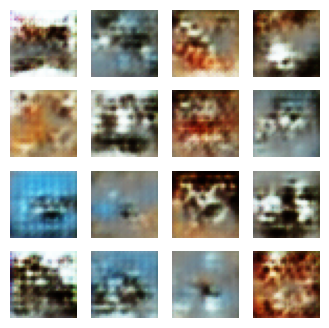

Epoch 41/200 완료, 시간: 3.47초, G_loss: 2.7381, D_loss: 0.3449
Epoch 42/200 완료, 시간: 3.46초, G_loss: 2.6748, D_loss: 0.4311
Epoch 43/200 완료, 시간: 3.46초, G_loss: 2.6069, D_loss: 0.4322
Epoch 44/200 완료, 시간: 3.45초, G_loss: 2.3565, D_loss: 0.4939
Epoch 45/200 완료, 시간: 3.45초, G_loss: 2.3541, D_loss: 0.4337
Epoch 46/200 완료, 시간: 3.46초, G_loss: 2.7722, D_loss: 0.3496
Epoch 47/200 완료, 시간: 3.47초, G_loss: 2.7124, D_loss: 0.3525
Epoch 48/200 완료, 시간: 3.46초, G_loss: 3.2330, D_loss: 0.2837
Epoch 49/200 완료, 시간: 3.48초, G_loss: 2.8472, D_loss: 0.3475
Epoch 50/200 완료, 시간: 3.47초, G_loss: 3.2315, D_loss: 0.2821


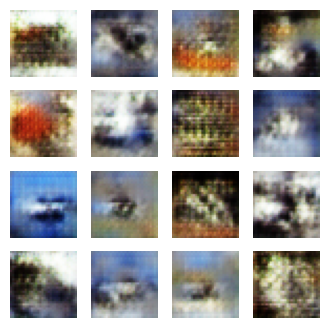

Epoch 51/200 완료, 시간: 3.47초, G_loss: 3.0397, D_loss: 0.3054
Epoch 52/200 완료, 시간: 3.47초, G_loss: 3.0607, D_loss: 0.2976
Epoch 53/200 완료, 시간: 3.47초, G_loss: 2.8762, D_loss: 0.3532
Epoch 54/200 완료, 시간: 3.47초, G_loss: 3.0195, D_loss: 0.2958
Epoch 55/200 완료, 시간: 3.47초, G_loss: 2.8314, D_loss: 0.3751
Epoch 56/200 완료, 시간: 3.51초, G_loss: 2.7528, D_loss: 0.3974
Epoch 57/200 완료, 시간: 3.48초, G_loss: 2.7450, D_loss: 0.3969
Epoch 58/200 완료, 시간: 3.47초, G_loss: 2.3817, D_loss: 0.4834
Epoch 59/200 완료, 시간: 3.47초, G_loss: 2.8740, D_loss: 0.3840
Epoch 60/200 완료, 시간: 3.46초, G_loss: 2.7430, D_loss: 0.3632


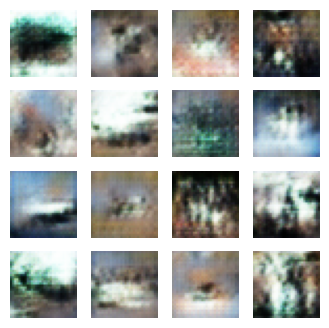

Epoch 61/200 완료, 시간: 3.48초, G_loss: 3.1255, D_loss: 0.2912
Epoch 62/200 완료, 시간: 3.47초, G_loss: 3.0885, D_loss: 0.3118
Epoch 63/200 완료, 시간: 3.47초, G_loss: 3.1963, D_loss: 0.3688
Epoch 64/200 완료, 시간: 3.47초, G_loss: 2.9109, D_loss: 0.4151
Epoch 65/200 완료, 시간: 3.46초, G_loss: 2.7599, D_loss: 0.4849
Epoch 66/200 완료, 시간: 3.47초, G_loss: 2.5987, D_loss: 0.4229
Epoch 67/200 완료, 시간: 3.47초, G_loss: 2.7414, D_loss: 0.3759
Epoch 68/200 완료, 시간: 3.47초, G_loss: 2.8511, D_loss: 0.4187
Epoch 69/200 완료, 시간: 3.46초, G_loss: 2.8202, D_loss: 0.4475
Epoch 70/200 완료, 시간: 3.47초, G_loss: 2.5612, D_loss: 0.4811


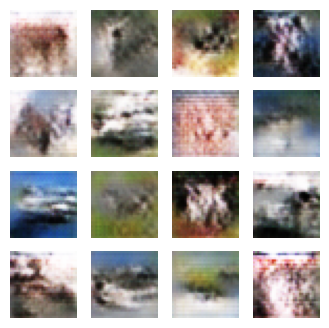

Epoch 71/200 완료, 시간: 3.47초, G_loss: 2.5405, D_loss: 0.5054
Epoch 72/200 완료, 시간: 3.46초, G_loss: 2.6910, D_loss: 0.3947
Epoch 73/200 완료, 시간: 3.51초, G_loss: 2.5509, D_loss: 0.4586
Epoch 74/200 완료, 시간: 3.47초, G_loss: 2.6491, D_loss: 0.3942
Epoch 75/200 완료, 시간: 3.47초, G_loss: 2.4703, D_loss: 0.5029
Epoch 76/200 완료, 시간: 3.47초, G_loss: 2.9716, D_loss: 0.3198
Epoch 77/200 완료, 시간: 3.47초, G_loss: 2.5935, D_loss: 0.4256
Epoch 78/200 완료, 시간: 3.48초, G_loss: 2.6193, D_loss: 0.4295
Epoch 79/200 완료, 시간: 3.46초, G_loss: 2.6568, D_loss: 0.4506
Epoch 80/200 완료, 시간: 3.47초, G_loss: 2.8439, D_loss: 0.4273


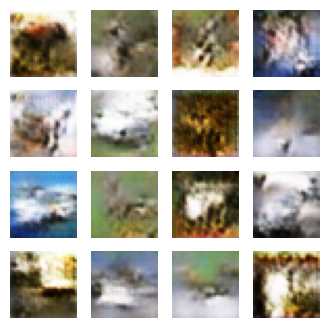

Epoch 81/200 완료, 시간: 3.47초, G_loss: 2.8664, D_loss: 0.3904
Epoch 82/200 완료, 시간: 3.46초, G_loss: 2.7099, D_loss: 0.4196
Epoch 83/200 완료, 시간: 3.47초, G_loss: 2.6294, D_loss: 0.4329
Epoch 84/200 완료, 시간: 3.47초, G_loss: 2.7522, D_loss: 0.4282
Epoch 85/200 완료, 시간: 3.47초, G_loss: 2.5445, D_loss: 0.4678
Epoch 86/200 완료, 시간: 3.47초, G_loss: 2.1417, D_loss: 0.6989
Epoch 87/200 완료, 시간: 3.47초, G_loss: 2.3690, D_loss: 0.5472
Epoch 88/200 완료, 시간: 3.48초, G_loss: 2.4266, D_loss: 0.5582
Epoch 89/200 완료, 시간: 3.48초, G_loss: 2.3307, D_loss: 0.5669
Epoch 90/200 완료, 시간: 3.48초, G_loss: 2.3534, D_loss: 0.4878


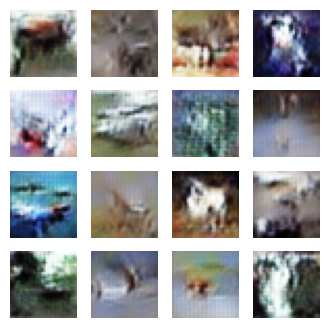

Epoch 91/200 완료, 시간: 3.47초, G_loss: 2.3031, D_loss: 0.5543
Epoch 92/200 완료, 시간: 3.46초, G_loss: 2.3551, D_loss: 0.5674
Epoch 93/200 완료, 시간: 3.47초, G_loss: 2.1833, D_loss: 0.5992
Epoch 94/200 완료, 시간: 3.46초, G_loss: 2.3321, D_loss: 0.5259
Epoch 95/200 완료, 시간: 3.47초, G_loss: 2.2817, D_loss: 0.6713
Epoch 96/200 완료, 시간: 3.47초, G_loss: 2.2772, D_loss: 0.6015
Epoch 97/200 완료, 시간: 3.47초, G_loss: 2.2591, D_loss: 0.6976
Epoch 98/200 완료, 시간: 3.48초, G_loss: 2.1601, D_loss: 0.7553
Epoch 99/200 완료, 시간: 3.48초, G_loss: 2.1685, D_loss: 0.5674
Epoch 100/200 완료, 시간: 3.47초, G_loss: 2.2427, D_loss: 0.5731


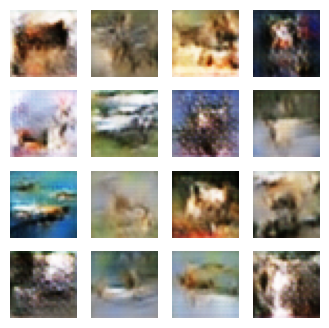

Epoch 101/200 완료, 시간: 3.47초, G_loss: 2.2373, D_loss: 0.6256
Epoch 102/200 완료, 시간: 3.48초, G_loss: 2.2266, D_loss: 0.5223
Epoch 103/200 완료, 시간: 3.48초, G_loss: 2.3052, D_loss: 0.5578
Epoch 104/200 완료, 시간: 3.47초, G_loss: 2.2617, D_loss: 0.5306
Epoch 105/200 완료, 시간: 3.48초, G_loss: 2.3246, D_loss: 0.4850
Epoch 106/200 완료, 시간: 3.47초, G_loss: 2.3736, D_loss: 0.5068
Epoch 107/200 완료, 시간: 3.46초, G_loss: 2.2644, D_loss: 0.5644
Epoch 108/200 완료, 시간: 3.51초, G_loss: 2.2915, D_loss: 0.5099
Epoch 109/200 완료, 시간: 3.47초, G_loss: 2.5627, D_loss: 0.4417
Epoch 110/200 완료, 시간: 3.47초, G_loss: 2.2114, D_loss: 0.5722


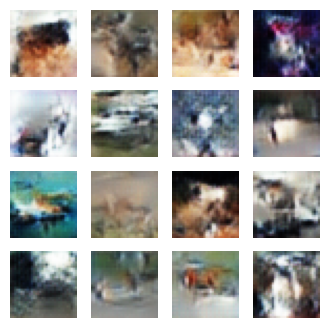

Epoch 111/200 완료, 시간: 3.47초, G_loss: 2.3102, D_loss: 0.5184
Epoch 112/200 완료, 시간: 3.47초, G_loss: 2.0535, D_loss: 0.6302
Epoch 113/200 완료, 시간: 3.48초, G_loss: 2.1673, D_loss: 0.5707
Epoch 114/200 완료, 시간: 3.47초, G_loss: 2.2117, D_loss: 0.5300
Epoch 115/200 완료, 시간: 3.49초, G_loss: 2.2317, D_loss: 0.5173
Epoch 116/200 완료, 시간: 3.49초, G_loss: 2.4349, D_loss: 0.4770
Epoch 117/200 완료, 시간: 3.49초, G_loss: 2.2498, D_loss: 0.5633
Epoch 118/200 완료, 시간: 3.52초, G_loss: 2.1801, D_loss: 0.5432
Epoch 119/200 완료, 시간: 3.52초, G_loss: 2.3708, D_loss: 0.5088
Epoch 120/200 완료, 시간: 5.10초, G_loss: 2.2767, D_loss: 0.4926


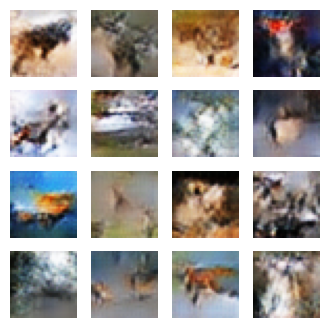

Epoch 121/200 완료, 시간: 3.53초, G_loss: 2.3942, D_loss: 0.4512
Epoch 122/200 완료, 시간: 3.50초, G_loss: 2.3184, D_loss: 0.4947
Epoch 123/200 완료, 시간: 3.48초, G_loss: 2.4261, D_loss: 0.5313
Epoch 124/200 완료, 시간: 3.53초, G_loss: 2.2103, D_loss: 0.5811
Epoch 125/200 완료, 시간: 3.48초, G_loss: 2.0399, D_loss: 0.6914
Epoch 126/200 완료, 시간: 3.48초, G_loss: 2.3757, D_loss: 0.4549
Epoch 127/200 완료, 시간: 3.47초, G_loss: 2.1570, D_loss: 0.5485
Epoch 128/200 완료, 시간: 3.49초, G_loss: 2.2259, D_loss: 0.5432
Epoch 129/200 완료, 시간: 3.49초, G_loss: 2.1868, D_loss: 0.5060
Epoch 130/200 완료, 시간: 3.48초, G_loss: 2.1605, D_loss: 0.5653


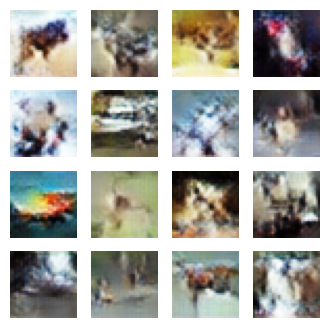

Epoch 131/200 완료, 시간: 3.49초, G_loss: 2.3414, D_loss: 0.5414
Epoch 132/200 완료, 시간: 3.49초, G_loss: 2.1080, D_loss: 0.5477
Epoch 133/200 완료, 시간: 3.50초, G_loss: 2.1969, D_loss: 0.5393
Epoch 134/200 완료, 시간: 3.50초, G_loss: 2.1981, D_loss: 0.5277
Epoch 135/200 완료, 시간: 3.49초, G_loss: 2.2795, D_loss: 0.4919
Epoch 136/200 완료, 시간: 3.49초, G_loss: 2.3068, D_loss: 0.5136
Epoch 137/200 완료, 시간: 3.49초, G_loss: 2.3053, D_loss: 0.5931
Epoch 138/200 완료, 시간: 3.50초, G_loss: 2.3255, D_loss: 0.4607
Epoch 139/200 완료, 시간: 3.49초, G_loss: 2.0934, D_loss: 0.5732
Epoch 140/200 완료, 시간: 3.50초, G_loss: 2.2205, D_loss: 0.5037


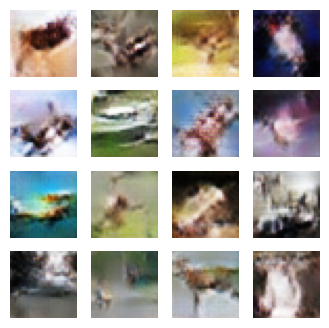

Epoch 141/200 완료, 시간: 3.48초, G_loss: 2.2727, D_loss: 0.4781
Epoch 142/200 완료, 시간: 3.48초, G_loss: 2.1532, D_loss: 0.5455
Epoch 143/200 완료, 시간: 3.49초, G_loss: 2.3315, D_loss: 0.4804
Epoch 144/200 완료, 시간: 3.49초, G_loss: 2.4343, D_loss: 0.4869
Epoch 145/200 완료, 시간: 3.48초, G_loss: 2.1893, D_loss: 0.5681
Epoch 146/200 완료, 시간: 3.48초, G_loss: 2.0818, D_loss: 0.5720
Epoch 147/200 완료, 시간: 3.48초, G_loss: 2.1221, D_loss: 0.5698
Epoch 148/200 완료, 시간: 3.46초, G_loss: 2.3345, D_loss: 0.5114
Epoch 149/200 완료, 시간: 3.47초, G_loss: 2.2236, D_loss: 0.5528
Epoch 150/200 완료, 시간: 3.48초, G_loss: 2.2690, D_loss: 0.5292


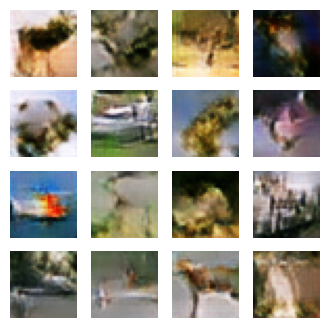

Epoch 151/200 완료, 시간: 3.47초, G_loss: 2.2821, D_loss: 0.4834
Epoch 152/200 완료, 시간: 3.47초, G_loss: 2.1880, D_loss: 0.5264
Epoch 153/200 완료, 시간: 3.49초, G_loss: 2.3041, D_loss: 0.6099
Epoch 154/200 완료, 시간: 3.47초, G_loss: 2.2829, D_loss: 0.5532
Epoch 155/200 완료, 시간: 3.47초, G_loss: 2.1290, D_loss: 0.6430
Epoch 156/200 완료, 시간: 3.47초, G_loss: 2.1474, D_loss: 0.5280
Epoch 157/200 완료, 시간: 3.48초, G_loss: 2.0298, D_loss: 0.6850
Epoch 158/200 완료, 시간: 3.48초, G_loss: 1.9606, D_loss: 0.7284
Epoch 159/200 완료, 시간: 3.52초, G_loss: 2.0100, D_loss: 0.6672
Epoch 160/200 완료, 시간: 3.48초, G_loss: 1.9206, D_loss: 0.7400


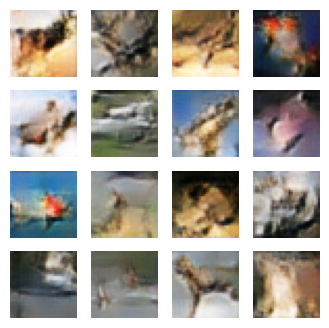

Epoch 161/200 완료, 시간: 3.47초, G_loss: 1.9298, D_loss: 0.7058
Epoch 162/200 완료, 시간: 3.47초, G_loss: 2.1637, D_loss: 0.5798
Epoch 163/200 완료, 시간: 3.47초, G_loss: 1.9175, D_loss: 0.6469
Epoch 164/200 완료, 시간: 3.49초, G_loss: 1.9138, D_loss: 0.6718
Epoch 165/200 완료, 시간: 3.47초, G_loss: 1.8373, D_loss: 0.8141
Epoch 166/200 완료, 시간: 3.48초, G_loss: 1.9665, D_loss: 0.6672
Epoch 167/200 완료, 시간: 3.48초, G_loss: 1.9283, D_loss: 0.6712
Epoch 168/200 완료, 시간: 3.47초, G_loss: 1.8761, D_loss: 0.7282
Epoch 169/200 완료, 시간: 3.46초, G_loss: 1.8939, D_loss: 0.6499
Epoch 170/200 완료, 시간: 3.48초, G_loss: 1.8516, D_loss: 0.7381


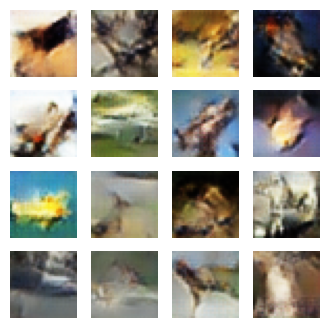

Epoch 171/200 완료, 시간: 3.48초, G_loss: 1.8402, D_loss: 0.7273
Epoch 172/200 완료, 시간: 3.48초, G_loss: 1.9005, D_loss: 0.7500
Epoch 173/200 완료, 시간: 3.47초, G_loss: 1.9998, D_loss: 0.6449
Epoch 174/200 완료, 시간: 3.48초, G_loss: 1.9901, D_loss: 0.7088
Epoch 175/200 완료, 시간: 3.47초, G_loss: 1.9554, D_loss: 0.6524
Epoch 176/200 완료, 시간: 3.52초, G_loss: 1.9707, D_loss: 0.6448
Epoch 177/200 완료, 시간: 3.48초, G_loss: 2.0981, D_loss: 0.6148
Epoch 178/200 완료, 시간: 3.48초, G_loss: 2.0134, D_loss: 0.6810
Epoch 179/200 완료, 시간: 3.48초, G_loss: 1.8791, D_loss: 0.7485
Epoch 180/200 완료, 시간: 3.47초, G_loss: 1.8743, D_loss: 0.7244


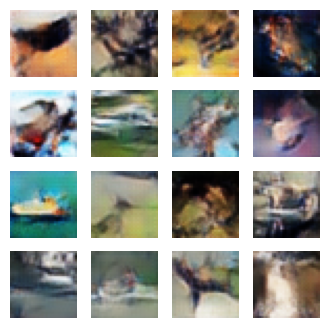

Epoch 181/200 완료, 시간: 3.48초, G_loss: 1.8030, D_loss: 0.7728
Epoch 182/200 완료, 시간: 3.47초, G_loss: 1.8756, D_loss: 0.7038
Epoch 183/200 완료, 시간: 3.48초, G_loss: 1.8480, D_loss: 0.7498
Epoch 184/200 완료, 시간: 3.48초, G_loss: 1.8769, D_loss: 0.7845
Epoch 185/200 완료, 시간: 3.48초, G_loss: 1.7118, D_loss: 0.8160
Epoch 186/200 완료, 시간: 3.48초, G_loss: 1.8538, D_loss: 0.6855
Epoch 187/200 완료, 시간: 3.47초, G_loss: 1.7399, D_loss: 0.8210
Epoch 188/200 완료, 시간: 3.48초, G_loss: 1.8334, D_loss: 0.7142
Epoch 189/200 완료, 시간: 3.47초, G_loss: 1.8470, D_loss: 0.8066
Epoch 190/200 완료, 시간: 3.48초, G_loss: 1.8657, D_loss: 0.7568


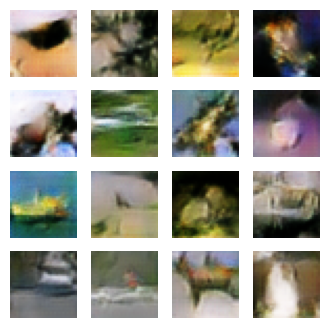

Epoch 191/200 완료, 시간: 3.47초, G_loss: 1.7813, D_loss: 0.7710
Epoch 192/200 완료, 시간: 3.47초, G_loss: 1.6036, D_loss: 0.8816
Epoch 193/200 완료, 시간: 3.53초, G_loss: 1.6981, D_loss: 0.8116
Epoch 194/200 완료, 시간: 3.47초, G_loss: 1.8762, D_loss: 0.7096
Epoch 195/200 완료, 시간: 3.48초, G_loss: 1.7040, D_loss: 0.8911
Epoch 196/200 완료, 시간: 3.47초, G_loss: 1.8008, D_loss: 0.7538
Epoch 197/200 완료, 시간: 3.47초, G_loss: 1.7911, D_loss: 0.7725
Epoch 198/200 완료, 시간: 3.48초, G_loss: 1.6362, D_loss: 0.8882
Epoch 199/200 완료, 시간: 3.47초, G_loss: 1.5949, D_loss: 0.9131
Epoch 200/200 완료, 시간: 3.48초, G_loss: 1.7388, D_loss: 0.8266


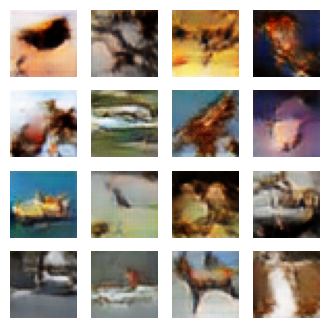

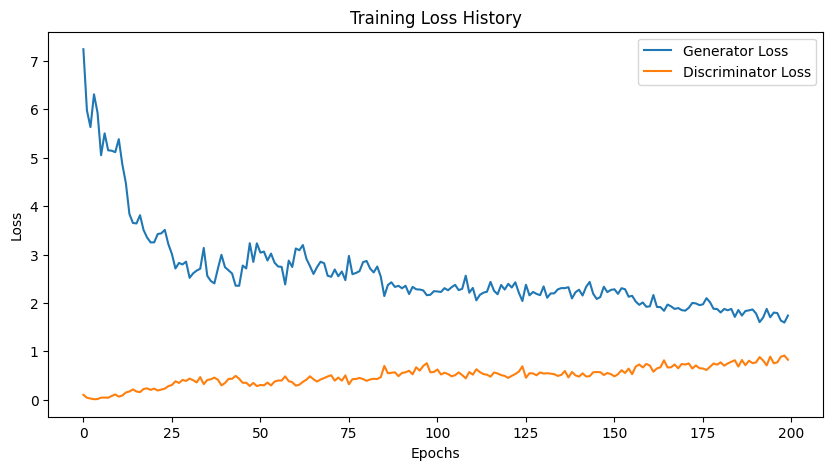

In [8]:
# ✅ 학습 실행
train(train_dataset, EPOCHS)


In [9]:
# ✅ GIF 생성 함수
def create_gif():
    anim_file = f"{generated_samples_dir}/cifar10_dcgan.gif"
    filenames = sorted(glob.glob(f"{generated_samples_dir}/image_at_epoch_*.png"))

    with imageio.get_writer(anim_file, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    print(f"✅ GIF 생성 완료! 저장 위치: {anim_file}")

create_gif()

<ipython-input-9-b4439c88aa60>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


✅ GIF 생성 완료! 저장 위치: /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/generated_samples/cifar10_dcgan.gif
